**Predicting Global Supply Chain**

Key Question: Can we use procurement transaction data to predict whether a delivery is delayed and estimating the length of the delay and price discovery

**Notebook 1: Data Cleaning & Feature Engineering**

**Part 1 Data Cleaning**

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import missingno as msno
import openpyxl
import helper as scmhelper
%matplotlib inline

Load the data files

In [2]:
# Data Source: https://data.pepfar.net/additionalData, downloaded as excel file
full = pd.ExcelFile('data/src/SCMS Data 20151023.xlsx')
print("Sheetnames: ",full.sheet_names)
parsed_data = scmhelper.parse_raw_data(full)
all_sheets_df = pd.read_excel(full, sheet_name=full.sheet_names[3])
print(all_sheets_df.shape )
#print(data.head(5))
for df in parsed_data:
    print(df.name," shape:",df.shape )

# View ref top rows
summary, purpose, ref, data = parsed_data
data.head(5)

Sheetnames:  ['Summary ', 'Data Purpose and Notes', 'Data Dictionary', 'SCMS Delivery History Dataset']
(10324, 33)
summary  shape: (0, 0)
purpose  shape: (0, 0)
ref  shape: (33, 5)
data  shape: (10324, 33)


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


Check Duplicates

In [3]:
data.duplicated().sum()

0

Rename Columns

In [4]:
newcol_list = ['id', 'proj_code', 'pq_no', 'po_no', 'ship_no', 'country'
     , 'mngr', 'fulfill_via','vendor_terms', 'ship_mode', 'pq_date'
     , 'po_date', 'del_date_scheduled' ,'del_date_client', 'del_date_recorded'
     , 'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand'
     , 'dosage','dosage_form', 'units', 'ln_itm_qty', 'ln_itm_val', 'pk_price'
     , 'unit_price', 'factory', 'first_line', 'weight', 'freight_cost', 'line_itm_ins']
data = scmhelper.rename_data_columns(data, newcol_list)

Old columns:  Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'PQ First Sent to Client Date', 'PO Sent to Vendor Date',
       'Scheduled Delivery Date', 'Delivered to Client Date',
       'Delivery Recorded Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)'],
      dtype='object')
New columns:  Index(['id', 'proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'del_date_scheduled', 'del_date_client', 'del_date_recorded',
       'prod_grp', 'sub_class', 'vendor', 'itm_

Update references

In [5]:
# Add these new columns to reference and make a lookup function in case we forget what it means
ref['NewColumn']= data.columns 
#ref.to_excel("Reference.xlsx") # save to disk
# Example usage of the reference function below:
scmhelper.getReferenceInfo(data, data.columns[5], ref)

5    Country
Name: FieldName, dtype: object 
, 5    Text
Name: DataType, dtype: object 
, 5    Destination country
Name: FieldDescription, dtype: object 
, 5    NaN
Name: FieldNotes, dtype: object 
          Examples: 
0    Côte d'Ivoire
1          Vietnam
2    Côte d'Ivoire
3          Vietnam
4          Vietnam
Name: country, dtype: object 



Converts data types

In [66]:
# First use helper function to get column report and blocks of data by column type
data_types = data.dtypes
unique_items = list(set(data_types))
print(unique_items[2])   
blocks = scmhelper.blocks_by_dtype(data)

int64
Total Number of Columns: 33
Breakdown....

Type: int64 , Count: 3 
Columns and null counts---: 
id            0
units         0
ln_itm_qty    0
dtype: int64

Type: object , Count: 23 
Columns and null counts---: 
proj_code           0
pq_no               0
po_no               0
ship_no             0
country             0
mngr                0
fulfill_via         0
vendor_terms        0
ship_mode         360
pq_date             0
po_date             0
prod_grp            0
sub_class           0
vendor              0
itm_desc            0
molecule_test       0
brand               0
dosage           1736
dosage_form         0
factory             0
first_line          0
weight              0
freight_cost        0
dtype: int64

Type: datetime64[ns] , Count: 3 
Columns and null counts---: 
del_date_scheduled    0
del_date_client       0
del_date_recorded     0
dtype: int64

Type: float64 , Count: 4 
Columns and null counts---: 
ln_itm_val        0
pk_price          0
unit_price        

In [67]:
blocks.keys()


dict_keys([dtype('int64'), dtype('O'), dtype('<M8[ns]'), dtype('float64')])

dict_keys(['float64', 'int64', 'datetime64[ns]', 'object'])

In [74]:
dint,dobject, ddate, dfloat  = [d for d in blocks.values()]
print(dfloat.shape, dint.shape, ddate.shape, dobject.shape)

(10324, 4) (10324, 3) (10324, 3) (10324, 23)


### Verify Missing Values



<Axes: >

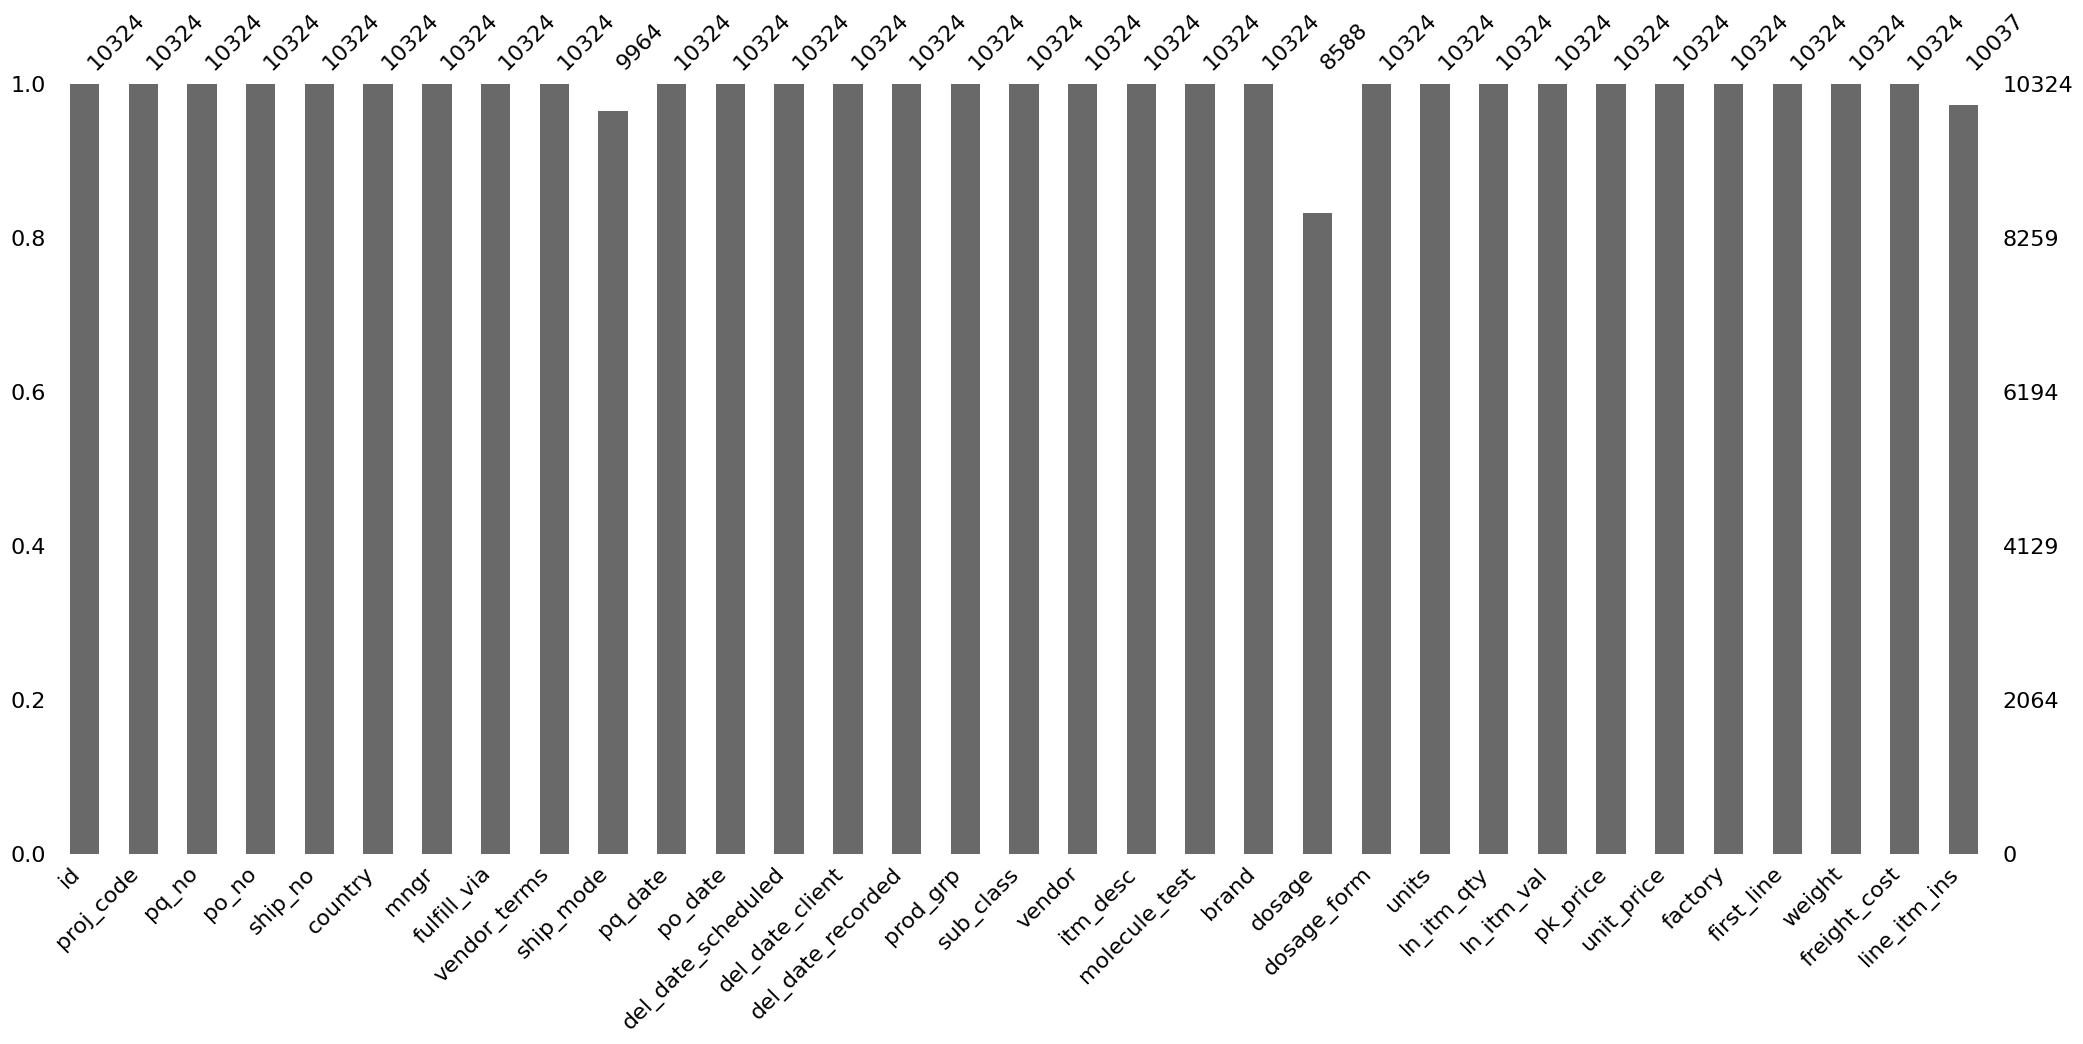

In [75]:
msno.bar(data, labels=True)

<Axes: >

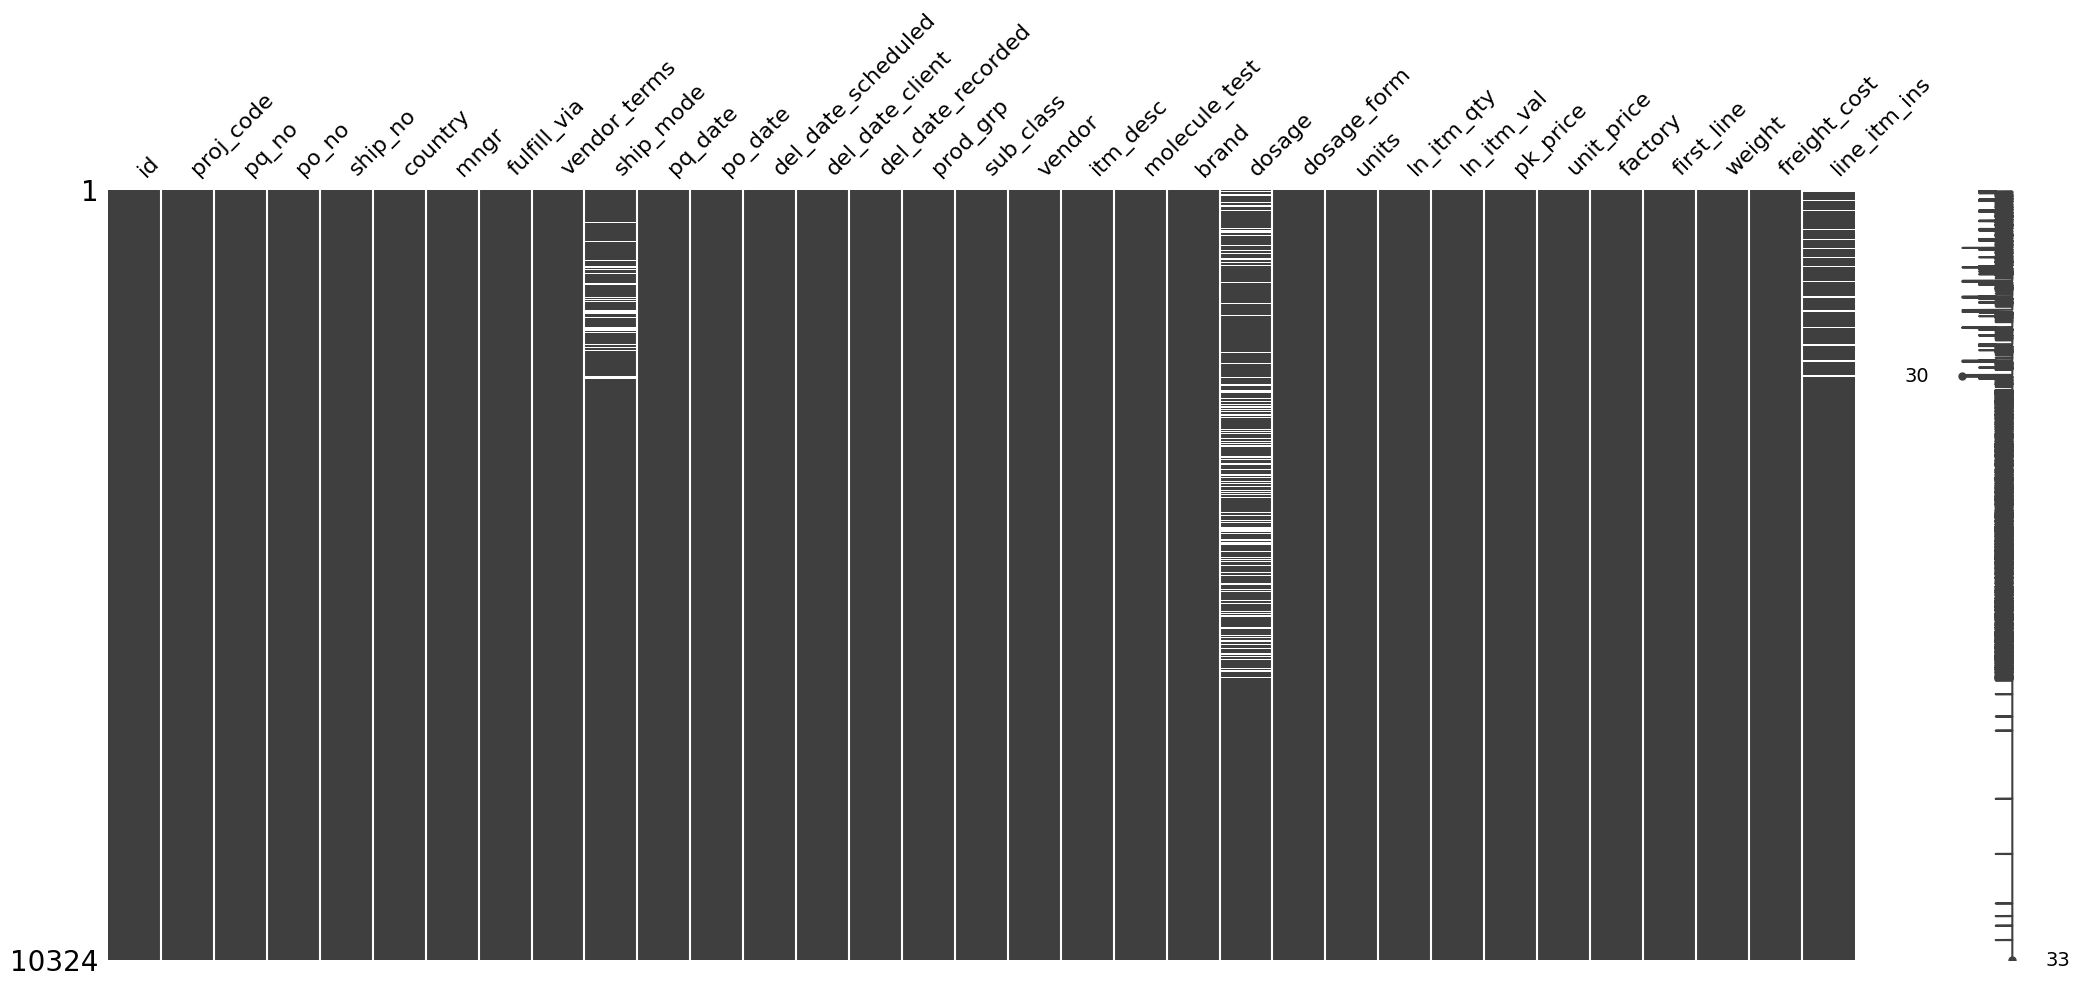

In [76]:
msno.matrix(data)

#### Missing values
From above, we can see that:

    -Dosage has a significant number of missing values
    - Line item Insurance and shipping mode have similarly moderate levels of missing values

*Fix Dosage Missing values*

In [77]:
#### Fix the missing values for the dosage feature
# Dosage has a lot of missing values
print(dobject.keys())
dosage_nulls = dobject[dobject.dosage.isnull()]
# dosage_nulls.to_excel("Dosage_Nulls.xlsx")
# Excel investigation: Corelated with country, item_desc (Mostly HIV rapid test kits), molecule test
#, vendor_terms (EXnW??), fulfill_via (by air), Brand, dosage_form, units?# pk_price, factory
dosage_lkup = dobject[[ 'itm_desc', 'molecule_test', 'brand', 'dosage_form', 'dosage' ]].groupby(
[ 'itm_desc', 'molecule_test', 'brand','dosage_form']).max()
# Realize they are all test kits, 
dosage_lkup[dosage_lkup.dosage.isnull()].reset_index().dosage_form.value_counts()

Index(['proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand',
       'dosage', 'dosage_form', 'factory', 'first_line', 'weight',
       'freight_cost'],
      dtype='object')


dosage_form
Test kit                37
Test kit - Ancillary     9
Name: count, dtype: int64

In [86]:
def data_fill_na(data, column, fillvalue):
    print("Before: \n:", data.isnull().sum()[data.isnull().sum()>0])
    # So use NA-TestKit/Ancillary as dosage value
    data[column].fillna(value=fillvalue, inplace=True)
    # Check the nulls once again, these should be mainly from the date columns
    print("---\nAfter: \n:", data.isnull().sum()[data.isnull().sum()>0])
    return data    

In [87]:
dobject = data_fill_na(dobject, 'dosage', 'TestKit/Ancillary')

Before: 
: ship_mode    360
dtype: int64
---
After: 
: ship_mode    360
dtype: int64


In [88]:
#### Fix the missing values for the dosage feature
# Dosage has a lot of missing values
def describe_nulls(data, column):
    nulls = data[data[column].isnull()]
    #nulls.to_excel(column+"_nulls.xlsx")
    for col in nulls:
        #print('\n',col,"nulls summary: \nCount: {} \nUnique: {} \nTop Freq: {}".format(col.count()
        #      ,len(col.unique()), col.values_count()[:3]))
        print('\n-------\n',nulls[col].describe())

In [89]:
describe_nulls(dobject, 'ship_mode')


-------
 count            360
unique            15
top       110-ZM-T01
freq              99
Name: proj_code, dtype: object

-------
 count                360
unique                 1
top       Pre-PQ Process
freq                 360
Name: pq_no, dtype: object

-------
 count            360
unique           220
top       SCMS-16600
freq              18
Name: po_no, dtype: object

-------
 count          360
unique         226
top       ASN-1520
freq            16
Name: ship_no, dtype: object

-------
 count               360
unique               12
top       Côte d'Ivoire
freq                113
Name: country, dtype: object

-------
 count          360
unique           1
top       PMO - US
freq           360
Name: mngr, dtype: object

-------
 count          360
unique           2
top       From RDC
freq           312
Name: fulfill_via, dtype: object

-------
 count                360
unique                 5
top       N/A - From RDC
freq                 312
Name: vendor_terms, dtype:

In [90]:
data, column, groupby = [dobject.copy(), 'ship_mode',['country', 'itm_desc', 'ship_mode']]
# make cx
cx=data.groupby(groupby).agg('count').reset_index()[['country', 'itm_desc', 'ship_mode']]
print(cx.shape, cx.columns)
cx = cx.groupby(['country', 'itm_desc']).min().reset_index()
# make cy
cy = pd.merge(data, cx, how='left', left_on=['country', 'itm_desc']
         , right_on=['country', 'itm_desc'], suffixes=('','_y'))
print(cy.shape, cy.columns)
# assign
cy['ship_mode'] = cy.ship_mode.where(cy.ship_mode.notnull(), cy.ship_mode_y)
still_null= cy.ship_mode.isnull().index # find remiaining nulls
a = data.ship_mode.value_counts()/data.ship_mode.value_counts().sum() # values distributed randomness 
for j in still_null:
    cy.loc[j,'ship_mode'] = np.random.choice([i for i in a.index], p=[v for v in a])
cy.ship_mode.isnull().sum()
# Drop
cy.drop('ship_mode_y', axis=1, inplace=True)
print(cy.shape)
dobject= cy.copy()

(1323, 3) Index(['country', 'itm_desc', 'ship_mode'], dtype='object')
(10324, 24) Index(['proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand',
       'dosage', 'dosage_form', 'factory', 'first_line', 'weight',
       'freight_cost', 'ship_mode_y'],
      dtype='object')
(10324, 23)
